In [26]:
from torch import nn, optim
import os
import shapely
import pandas as pd
import geopandas as gpd
import numpy as np
from numpy.random import default_rng
import torch
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
import libpysal
import matplotlib.pyplot as plt
from copy import deepcopy

In [27]:
def load_data(year):
    os.getcwd()
    df = pd.DataFrame()
    path = "../Data/filled/" + str(year) + "/"
    for filename in os.listdir(path):
        print(filename)
        df1 = pd.read_csv(path + filename)
        if df1.geometry.isna().any():
            print(filename)
        df = pd.concat([df, df1])
    df = gpd.GeoDataFrame(df)
    df.geometry = df.geometry.apply(shapely.wkt.loads)
    
    df = df.reset_index()
    df = df.drop(["Unnamed: 0", "index"], axis = 1)
    return df

In [28]:
import torch
# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = "cpu"
print("Device: {}".format(device))

Device: cpu


In [29]:
df15 = load_data(2015).set_index("C28992R100")
df16 = load_data(2016).set_index("C28992R100")
df17 = load_data(2017).set_index("C28992R100")
df18 = load_data(2018).set_index("C28992R100")
df19 = load_data(2019).set_index("C28992R100")


eindhoven15.csv_filled_.csv
eindhoven16.csv_filled_.csv
eindhoven17.csv_filled_.csv
eindhoven18.csv_filled_.csv
eindhoven19.csv_filled_.csv


In [30]:
# Get data that is available in all years
overlapping1517 = df17.index[df17.index.isin(df16.index[df16.index.isin(df15.index)])]
overlapping1518 = df18.index[df18.index.isin(overlapping1517)]
overlapping1519 = df19.index[df19.index.isin(overlapping1518)]

# Fill X and Y
X = np.zeros((len(overlapping1519), 5, 40))
Y = np.zeros((len(overlapping1519), 5))
Y_1 = np.zeros((len(overlapping1519), 5))
ss = StandardScaler()

for i, df in enumerate([df15, df16, df17, df18, df19]):
    X[:,i] = df[df.columns[:-3]].loc[overlapping1519]
    Y[:,i] = df.loc[overlapping1519]["y"]
    Y_1[:,i] = df.loc[overlapping1519]["y-1"]


In [31]:
# Create neighbor lists for all years

df15 = df15.loc[overlapping1519]
df16 = df16.loc[overlapping1519]
df17 = df17.loc[overlapping1519]
df18 = df18.loc[overlapping1519]
df19 = df19.loc[overlapping1519]


w15 = libpysal.weights.DistanceBand.from_dataframe(df15.reset_index(), threshold=150, binary = True, silence_warnings = True)
w16 = libpysal.weights.DistanceBand.from_dataframe(df16.reset_index(), threshold=150, binary = True, silence_warnings = True)
w17 = libpysal.weights.DistanceBand.from_dataframe(df17.reset_index(), threshold=150, binary = True, silence_warnings = True)
w18 = libpysal.weights.DistanceBand.from_dataframe(df18.reset_index(), threshold=150, binary = True, silence_warnings = True)
w19 = libpysal.weights.DistanceBand.from_dataframe(df19.reset_index(), threshold=150, binary = True, silence_warnings = True)

In [32]:
# create Y(t-1) for all years

def get_y_1(y1, w):
    neighbors = [w.neighbors[x] for x in w.neighbors]
    y1 = np.array([y1[x].sum() for x in neighbors])
    y1[np.where(y1 == 0)[0]] = 0.5

    return y1

Y1_15 = get_y_1(Y_1[:,0], w15)
Y1_16 = get_y_1(Y_1[:,1], w16)
Y1_17 = get_y_1(Y_1[:,2], w17)
Y1_18 = get_y_1(Y_1[:,3], w18)
Y1_19 = get_y_1(Y_1[:,4], w19)



In [33]:
rng = default_rng()
def get_batch(X, Y, Y1, batch_size = 32):
    idxs = rng.integers(len(X), size = batch_size)
    return X[idxs], Y[idxs], Y1[idxs]



In [34]:
# X train is the first three years
X_train = X[:,:3]

#fill X_train Y(t-1) with actual values for resampling
X_train[:,0,39] = Y1_15
X_train[:,1,39] = Y1_16
X_train[:,2,39] = Y1_17

X_train = X_train.reshape(-1, 40*3)


Y_train = Y[:,2]


In [35]:
# oversample X_train using SMOTE

smote = SMOTE()
X_train_resample,Y_train_resample = smote.fit_resample(X_train,Y_train)
X_train = X_train.reshape(-1,3,40)
X_train_resample = X_train_resample.reshape(-1,3,40)

# transform Y(t-1) to proper values

Y1_17r = X_train_resample[:,2,-1]
Y1_17r[Y1_17r>0.5] =  np.ceil(Y1_17r[Y1_17r > 0.5])

X_train_resample = np.delete(X_train_resample, -1, 2)
X_train = np.delete(X_train, -1, 2)

X_train = X_train.reshape(-1, 39)
X_train_resample = X_train_resample.reshape(-1, 39)

# Fit and transform the standard scaler
X_train = ss.fit_transform(X_train)
X_train_resample = ss.transform(X_train_resample)

X_train_resample = X_train_resample.reshape(-1,3, 39)

Y1_17r = torch.tensor(Y1_17r).float().to(device).to(device)
Y1_18 = torch.tensor(Y1_18).float().to(device).to(device)

In [36]:
# create X_val and X_test
X_val = X[:,:4]
Y_val = Y[:,3]
X_val = np.delete(X_val, -1, 2)

X_val = X_val.reshape(-1, 39)
X_val = ss.transform(X_val)
X_val = X_val.reshape(-1, 4, 39)



X_test = X[:,:5]
Y_test = Y[:,4]
X_test = np.delete(X_test, -1, 2)
X_test = X_test.reshape(-1, 39)

X_test = ss.transform(X_test)
X_test = X_test.reshape(-1, 5, 39)

X_val = torch.tensor(X_val).float().to(device)
X_test = torch.tensor(X_test).float().to(device)




In [37]:
Y_val = torch.tensor(Y_val).float().to(device)
X_train_resample = torch.tensor(X_train_resample).float().to(device)
Y_train_resample = torch.tensor(Y_train_resample).float().to(device)


In [38]:
class RNN(nn.Module):
    def __init__(self):
        super(RNN, self).__init__()
        self.GRU = nn.GRU(input_size = 39, dropout = 0.2,num_layers = 2,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        return X


In [39]:
class RNN1(nn.Module):
    def __init__(self):
        super(RNN1, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 20, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(20,1),

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 20)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [40]:
class RNN2(nn.Module):
    def __init__(self):
        super(RNN2, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [41]:
class RNN3(nn.Module):
    def __init__(self):
        super(RNN3, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 2,hidden_size = 100, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(100,250),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(250,100),
            nn.ReLU(),
            nn.Linear(100,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(2, X.size(0), 100)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [42]:
class RNN4(nn.Module):
    def __init__(self):
        super(RNN4, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,100),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(100,50),
            nn.ReLU(),
            nn.Linear(50,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [43]:
class RNN5(nn.Module):
    def __init__(self):
        super(RNN5, self).__init__()
        self.GRU = nn.GRU(input_size = 39, num_layers = 1,hidden_size = 50, batch_first = True)
        self.net = nn.Sequential(
            nn.Linear(50,150),
            nn.Dropout(0.3),
            nn.ReLU(),
            nn.Linear(150,150),
            nn.ReLU(),
            nn.Linear(150,1)

        )
        self.final = nn.Sigmoid()
    def forward(self, X, Y1):
        h0 = torch.zeros(1, X.size(0), 50)
        X, _ = self.GRU(X, h0)
        X = X[:,-1, :].unsqueeze(1)
        X = self.net(X[:,-1])
        X = X.squeeze() * Y1
 
        
        return X

In [44]:
model = RNN().to(device)
model1 = RNN1().to(device)
model2 = RNN2().to(device)
model3 = RNN3().to(device)
model4 = RNN4().to(device)
model5 = RNN5().to(device)

models = [0]

In [45]:
def train(models, X_train, Y_train, Y1_train, X_val, Y_val, Y1_val, num_epochs, lr, batch_per_e = 100 ):

    best_auc, best_f1, best_model, best_epoch, best_lr = 0,0,0,0,0
    
    for i, model in enumerate(models):
        for lr in [0.00000051, 0.0000051]:
#         for lr in [0.0000051]:
                
            if model == 0: model = RNN()         
            elif model ==1: model = RNN1()                
            elif model == 2: model = RNN2()
            elif model == 3: model = RNN3()
            elif model == 4: model = RNN4()
            else: model = RNN5()
           
            ROC_history = []     
            optimizer = optim.Adam(model.parameters(), lr=lr) 
            SigBCEloss = nn.BCEWithLogitsLoss()
            
            for epoch in range(num_epochs):
                epoch_loss = []
#                 print("epoch: {} of {}".format(epoch, num_epochs))
                for batch in range(batch_per_e):

                    x, y, y1 = get_batch(X_train, Y_train, Y1_train, 6)

                    model.train()

                    optimizer.zero_grad()
                    out = model(x, y1).squeeze()


                    loss = SigBCEloss(out, y)
                    loss.backward()
                    optimizer.step()


                    epoch_loss.append(loss.detach().numpy())

                model.eval()

                out = model(X_val, Y1_val)
                ROC = roc_auc_score(Y_val, model.final(out).detach().numpy())
                out = out.squeeze().detach().numpy()

                preds = np.zeros(len(out))
                pos = out.argsort()[-((Y_val == 1).sum()):]
                preds[pos] = 1
                
                f1 = f1_score(Y_val, preds)

                ROC_history.append(ROC)

                if ROC > best_auc:
                    print("model: {}, ROC:{}, f1: {}, lr: {}, epoch = {}".format(i, ROC, f1, lr, epoch))
                    best_auc = ROC
                    best_f1 = f1
                    best_model = deepcopy(model.state_dict())
                    best_epoch = epoch
                    best_lr = lr

                train_loss = []
                          
            print(np.max(ROC_history), np.argmax(ROC_history), lr)
            plt.plot(ROC_history, alpha = 0.5)
            plt.hlines(np.mean(ROC_history), 0, n_epochs, color = "r") 
            linear_model=np.polyfit(range(n_epochs), ROC_history, 2)
            linear_model_fn=np.poly1d(linear_model)
            x_s=np.arange(0,n_epochs)
            plt.plot(linear_model_fn(x_s))  
            plt.show()
                          
    result = np.argmax(ROC_history)
    return best_auc, best_f1, best_model, best_epoch

model: 0, ROC:0.4351520958741224, f1: 0.08463251670378619, lr: 5.1e-07, epoch = 0
model: 0, ROC:0.43545057237257945, f1: 0.08463251670378619, lr: 5.1e-07, epoch = 1
model: 0, ROC:0.43576741355079274, f1: 0.08463251670378619, lr: 5.1e-07, epoch = 2
model: 0, ROC:0.436160740593046, f1: 0.08463251670378619, lr: 5.1e-07, epoch = 3
model: 0, ROC:0.4365784866050851, f1: 0.08463251670378619, lr: 5.1e-07, epoch = 4
model: 0, ROC:0.43694335848419946, f1: 0.08463251670378619, lr: 5.1e-07, epoch = 5
model: 0, ROC:0.4373201371337054, f1: 0.08463251670378619, lr: 5.1e-07, epoch = 6
model: 0, ROC:0.43755786892219917, f1: 0.08685968819599109, lr: 5.1e-07, epoch = 7
model: 0, ROC:0.4379398946230639, f1: 0.08908685968819599, lr: 5.1e-07, epoch = 8
model: 0, ROC:0.43827812762604834, f1: 0.08908685968819599, lr: 5.1e-07, epoch = 9
model: 0, ROC:0.4386270565414182, f1: 0.08908685968819599, lr: 5.1e-07, epoch = 10
model: 0, ROC:0.43909626401870855, f1: 0.08908685968819599, lr: 5.1e-07, epoch = 11
model: 0,

model: 0, ROC:0.47724313463691614, f1: 0.10690423162583519, lr: 5.1e-07, epoch = 99
model: 0, ROC:0.47766148607795833, f1: 0.10690423162583519, lr: 5.1e-07, epoch = 100
model: 0, ROC:0.4780731777999679, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 101
model: 0, ROC:0.4785504576639643, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 102
model: 0, ROC:0.4788578137877979, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 103
model: 0, ROC:0.47951308977866325, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 104
model: 0, ROC:0.4799199380686492, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 105
model: 0, ROC:0.48038773287826597, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 106
model: 0, ROC:0.4808680398872772, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 107
model: 0, ROC:0.4811998149808967, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 108
model: 0, ROC:0.4815362316968722, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 109
model: 0, ROC:0.48181916885092, f1: 0.1091314031180401, lr: 5.1e-07, epoch = 110
m

model: 0, ROC:0.5211748793783616, f1: 0.1291759465478842, lr: 5.1e-07, epoch = 197
model: 0, ROC:0.5216582135323876, f1: 0.1291759465478842, lr: 5.1e-07, epoch = 198
model: 0, ROC:0.5221532526471374, f1: 0.1291759465478842, lr: 5.1e-07, epoch = 199
model: 0, ROC:0.5226392103268429, f1: 0.1291759465478842, lr: 5.1e-07, epoch = 200
model: 0, ROC:0.5232712782059282, f1: 0.1291759465478842, lr: 5.1e-07, epoch = 201
model: 0, ROC:0.5238300891756559, f1: 0.1291759465478842, lr: 5.1e-07, epoch = 202
model: 0, ROC:0.5243233120033969, f1: 0.1291759465478842, lr: 5.1e-07, epoch = 203
model: 0, ROC:0.5248786922087745, f1: 0.13140311804008908, lr: 5.1e-07, epoch = 204
model: 0, ROC:0.5252944201241372, f1: 0.13140311804008908, lr: 5.1e-07, epoch = 205
model: 0, ROC:0.5259010599850984, f1: 0.13140311804008908, lr: 5.1e-07, epoch = 206
model: 0, ROC:0.5263569480243238, f1: 0.13140311804008908, lr: 5.1e-07, epoch = 207
model: 0, ROC:0.5268021401511636, f1: 0.13140311804008908, lr: 5.1e-07, epoch = 208

model: 0, ROC:0.5554942278398858, f1: 0.14699331848552338, lr: 5.1e-07, epoch = 296
model: 0, ROC:0.5556845343564815, f1: 0.14699331848552338, lr: 5.1e-07, epoch = 297
model: 0, ROC:0.5559842217129444, f1: 0.14699331848552338, lr: 5.1e-07, epoch = 298
model: 0, ROC:0.5562334566524942, f1: 0.14699331848552338, lr: 5.1e-07, epoch = 299
model: 0, ROC:0.5565686625104638, f1: 0.14699331848552338, lr: 5.1e-07, epoch = 300
model: 0, ROC:0.556787020570863, f1: 0.14699331848552338, lr: 5.1e-07, epoch = 301
model: 0, ROC:0.5569516972596669, f1: 0.14699331848552338, lr: 5.1e-07, epoch = 302
model: 0, ROC:0.5572090045859228, f1: 0.1492204899777283, lr: 5.1e-07, epoch = 303
model: 0, ROC:0.5575203969031095, f1: 0.1492204899777283, lr: 5.1e-07, epoch = 304
model: 0, ROC:0.5577785114680361, f1: 0.1492204899777283, lr: 5.1e-07, epoch = 305
model: 0, ROC:0.5580729517731401, f1: 0.1492204899777283, lr: 5.1e-07, epoch = 306
model: 0, ROC:0.558371428271597, f1: 0.1492204899777283, lr: 5.1e-07, epoch = 307

model: 0, ROC:0.5780153795111524, f1: 0.1603563474387528, lr: 5.1e-07, epoch = 395
model: 0, ROC:0.5782418099582578, f1: 0.1603563474387528, lr: 5.1e-07, epoch = 396
model: 0, ROC:0.5784726802180513, f1: 0.1603563474387528, lr: 5.1e-07, epoch = 397
model: 0, ROC:0.5786543089189379, f1: 0.1603563474387528, lr: 5.1e-07, epoch = 398
model: 0, ROC:0.5788359376198245, f1: 0.16258351893095768, lr: 5.1e-07, epoch = 399
model: 0, ROC:0.5790452142451794, f1: 0.16258351893095768, lr: 5.1e-07, epoch = 400
model: 0, ROC:0.5792625632572403, f1: 0.16481069042316257, lr: 5.1e-07, epoch = 401
model: 0, ROC:0.579497469710387, f1: 0.16481069042316257, lr: 5.1e-07, epoch = 402
model: 0, ROC:0.5797713254293904, f1: 0.16481069042316257, lr: 5.1e-07, epoch = 403
model: 0, ROC:0.5799398365018797, f1: 0.16481069042316257, lr: 5.1e-07, epoch = 404
model: 0, ROC:0.5801174290094133, f1: 0.16703786191536749, lr: 5.1e-07, epoch = 405
model: 0, ROC:0.580350519175551, f1: 0.16703786191536749, lr: 5.1e-07, epoch = 40

model: 0, ROC:0.5943516702978954, f1: 0.1759465478841871, lr: 5.1e-07, epoch = 493
model: 0, ROC:0.5944870845848896, f1: 0.1759465478841871, lr: 5.1e-07, epoch = 494
model: 0, ROC:0.5946370291679549, f1: 0.17817371937639198, lr: 5.1e-07, epoch = 495
model: 0, ROC:0.5947502443915076, f1: 0.17817371937639198, lr: 5.1e-07, epoch = 496
model: 0, ROC:0.5948701193340926, f1: 0.17817371937639198, lr: 5.1e-07, epoch = 497
model: 0, ROC:0.595014816865799, f1: 0.17817371937639198, lr: 5.1e-07, epoch = 498
model: 0, ROC:0.5952059306210652, f1: 0.17817371937639198, lr: 5.1e-07, epoch = 499
0.5952059306210652 499 5.1e-07


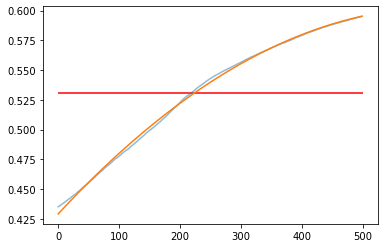

model: 0, ROC:0.6066913224264625, f1: 0.1714922048997773, lr: 5.1e-06, epoch = 2
model: 0, ROC:0.6199457777784954, f1: 0.19376391982182625, lr: 5.1e-06, epoch = 3
model: 0, ROC:0.6344579109793338, f1: 0.22271714922049, lr: 5.1e-06, epoch = 4
model: 0, ROC:0.6398153522264853, f1: 0.22939866369710468, lr: 5.1e-06, epoch = 5
model: 0, ROC:0.6438154216490111, f1: 0.23162583518930957, lr: 5.1e-06, epoch = 6
model: 0, ROC:0.6471632422256861, f1: 0.22494432071269488, lr: 5.1e-06, epoch = 7
model: 0, ROC:0.6502807979715706, f1: 0.22271714922049, lr: 5.1e-06, epoch = 8
model: 0, ROC:0.6522680177689376, f1: 0.22271714922049, lr: 5.1e-06, epoch = 9
model: 0, ROC:0.6531684925059998, f1: 0.22271714922049, lr: 5.1e-06, epoch = 10
model: 0, ROC:0.6546604713789492, f1: 0.22048997772828507, lr: 5.1e-06, epoch = 11
model: 0, ROC:0.655918149227755, f1: 0.22048997772828507, lr: 5.1e-06, epoch = 12
model: 0, ROC:0.6571843030826022, f1: 0.2182628062360802, lr: 5.1e-06, epoch = 13
model: 0, ROC:0.65805632265

model: 0, ROC:0.6759639035156051, f1: 0.24498886414253898, lr: 5.1e-06, epoch = 111
model: 0, ROC:0.6761554208902066, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 112
model: 0, ROC:0.6762173764581758, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 113
model: 0, ROC:0.676249666005, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 114
model: 0, ROC:0.6763132360503104, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 117
model: 0, ROC:0.6764817471227995, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 118
model: 0, ROC:0.6765077805699267, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 120
model: 0, ROC:0.6765259434400154, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 122
model: 0, ROC:0.6765640854672015, f1: 0.24053452115812918, lr: 5.1e-06, epoch = 128
model: 0, ROC:0.6766137306454438, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 129
model: 0, ROC:0.676692436415828, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 131
model: 0, ROC:0.6767560064611382, f1: 0.24276169265033407, lr: 5.1e-06, epoch = 1

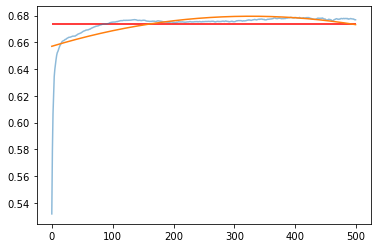

In [46]:
n_epochs = 500
hists = train(models, X_train_resample, Y_train_resample, Y1_17r, X_val, Y_val, Y1_18, n_epochs, 0.0000051)

In [47]:
hists

(0.6786544300047386,
 0.25389755011135856,
 OrderedDict([('GRU.weight_ih_l0',
               tensor([[-0.0652,  0.0437,  0.1188,  ...,  0.0109,  0.0815,  0.0649],
                       [ 0.0125,  0.0899, -0.0255,  ..., -0.1286, -0.1415,  0.1116],
                       [ 0.0473, -0.0334, -0.0315,  ..., -0.0027, -0.0440,  0.1527],
                       ...,
                       [ 0.1201,  0.0629,  0.1249,  ..., -0.0942, -0.0538,  0.1205],
                       [ 0.0790, -0.0801, -0.1294,  ...,  0.0992, -0.0303,  0.0490],
                       [-0.0132,  0.1065,  0.0337,  ..., -0.0584,  0.0545, -0.1187]])),
              ('GRU.weight_hh_l0',
               tensor([[ 0.0529,  0.0422, -0.1324,  ..., -0.0014,  0.0967,  0.1204],
                       [-0.1023, -0.0326,  0.1419,  ..., -0.0663, -0.0869, -0.1002],
                       [-0.1178,  0.0536, -0.0432,  ..., -0.0916,  0.0645, -0.0514],
                       ...,
                       [-0.0203,  0.0788,  0.0383,  ..., -0.020

best model: model 2, auc = 0.(0.7132703366008875,

f1: 0.3506410256410256,, lr =  5.1e-06

In [48]:
model = RNN5()
model.load_state_dict(hists[2])
model.eval()

out = model(X_test, torch.tensor(Y1_19))

ROC = roc_auc_score(Y_test, model.final(out).detach().numpy())
out = out.squeeze().detach().numpy()

preds = np.zeros(len(out))
pos = out.argsort()[-((Y_test == 1).sum()):]
preds[pos] = 1

f1 = f1_score(Y_test, preds)
print(ROC, f1)
# with open ("../Results/Eindhoven.csv", "a+") as f:
#     f.write("\nRNN,{},{}".format(ROC,f1))

0.6885526576088844 0.2608695652173913


0.6901539484868715 0


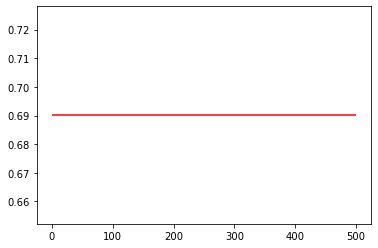

In [71]:
print(np.max(hists[-4]), np.argmax(hists[-4]))
plt.plot(hists[-4], alpha = 0.5)
plt.hlines(np.mean(hists[-4]), 0, n_epochs, color = "r")

In [49]:
import pickle
f = open('../results/EHRNNpreds','wb')
pickle.dump(out,f)
f.close()

In [50]:
with open ("../Results/modellen.csv", "a+") as f:
    f.write("EH,RNN,model5\n")

In [100]:
df19["preds"] = preds
df19["predicted"] = 0
df19 = df19.reset_index()

In [101]:
def checker(d):
    if d["y"] == 0 and d["preds"] == 0:
        return 0
    if d["y"] == 0 and d["preds"] == 1:
        return 1
    if d["y"] == 1 and d["preds"] == 0:
        return 2
    if d["y"] == 1 and d["preds"] == 1:
        return 3
    
df19["checked"] = df19.apply(checker, axis =1)

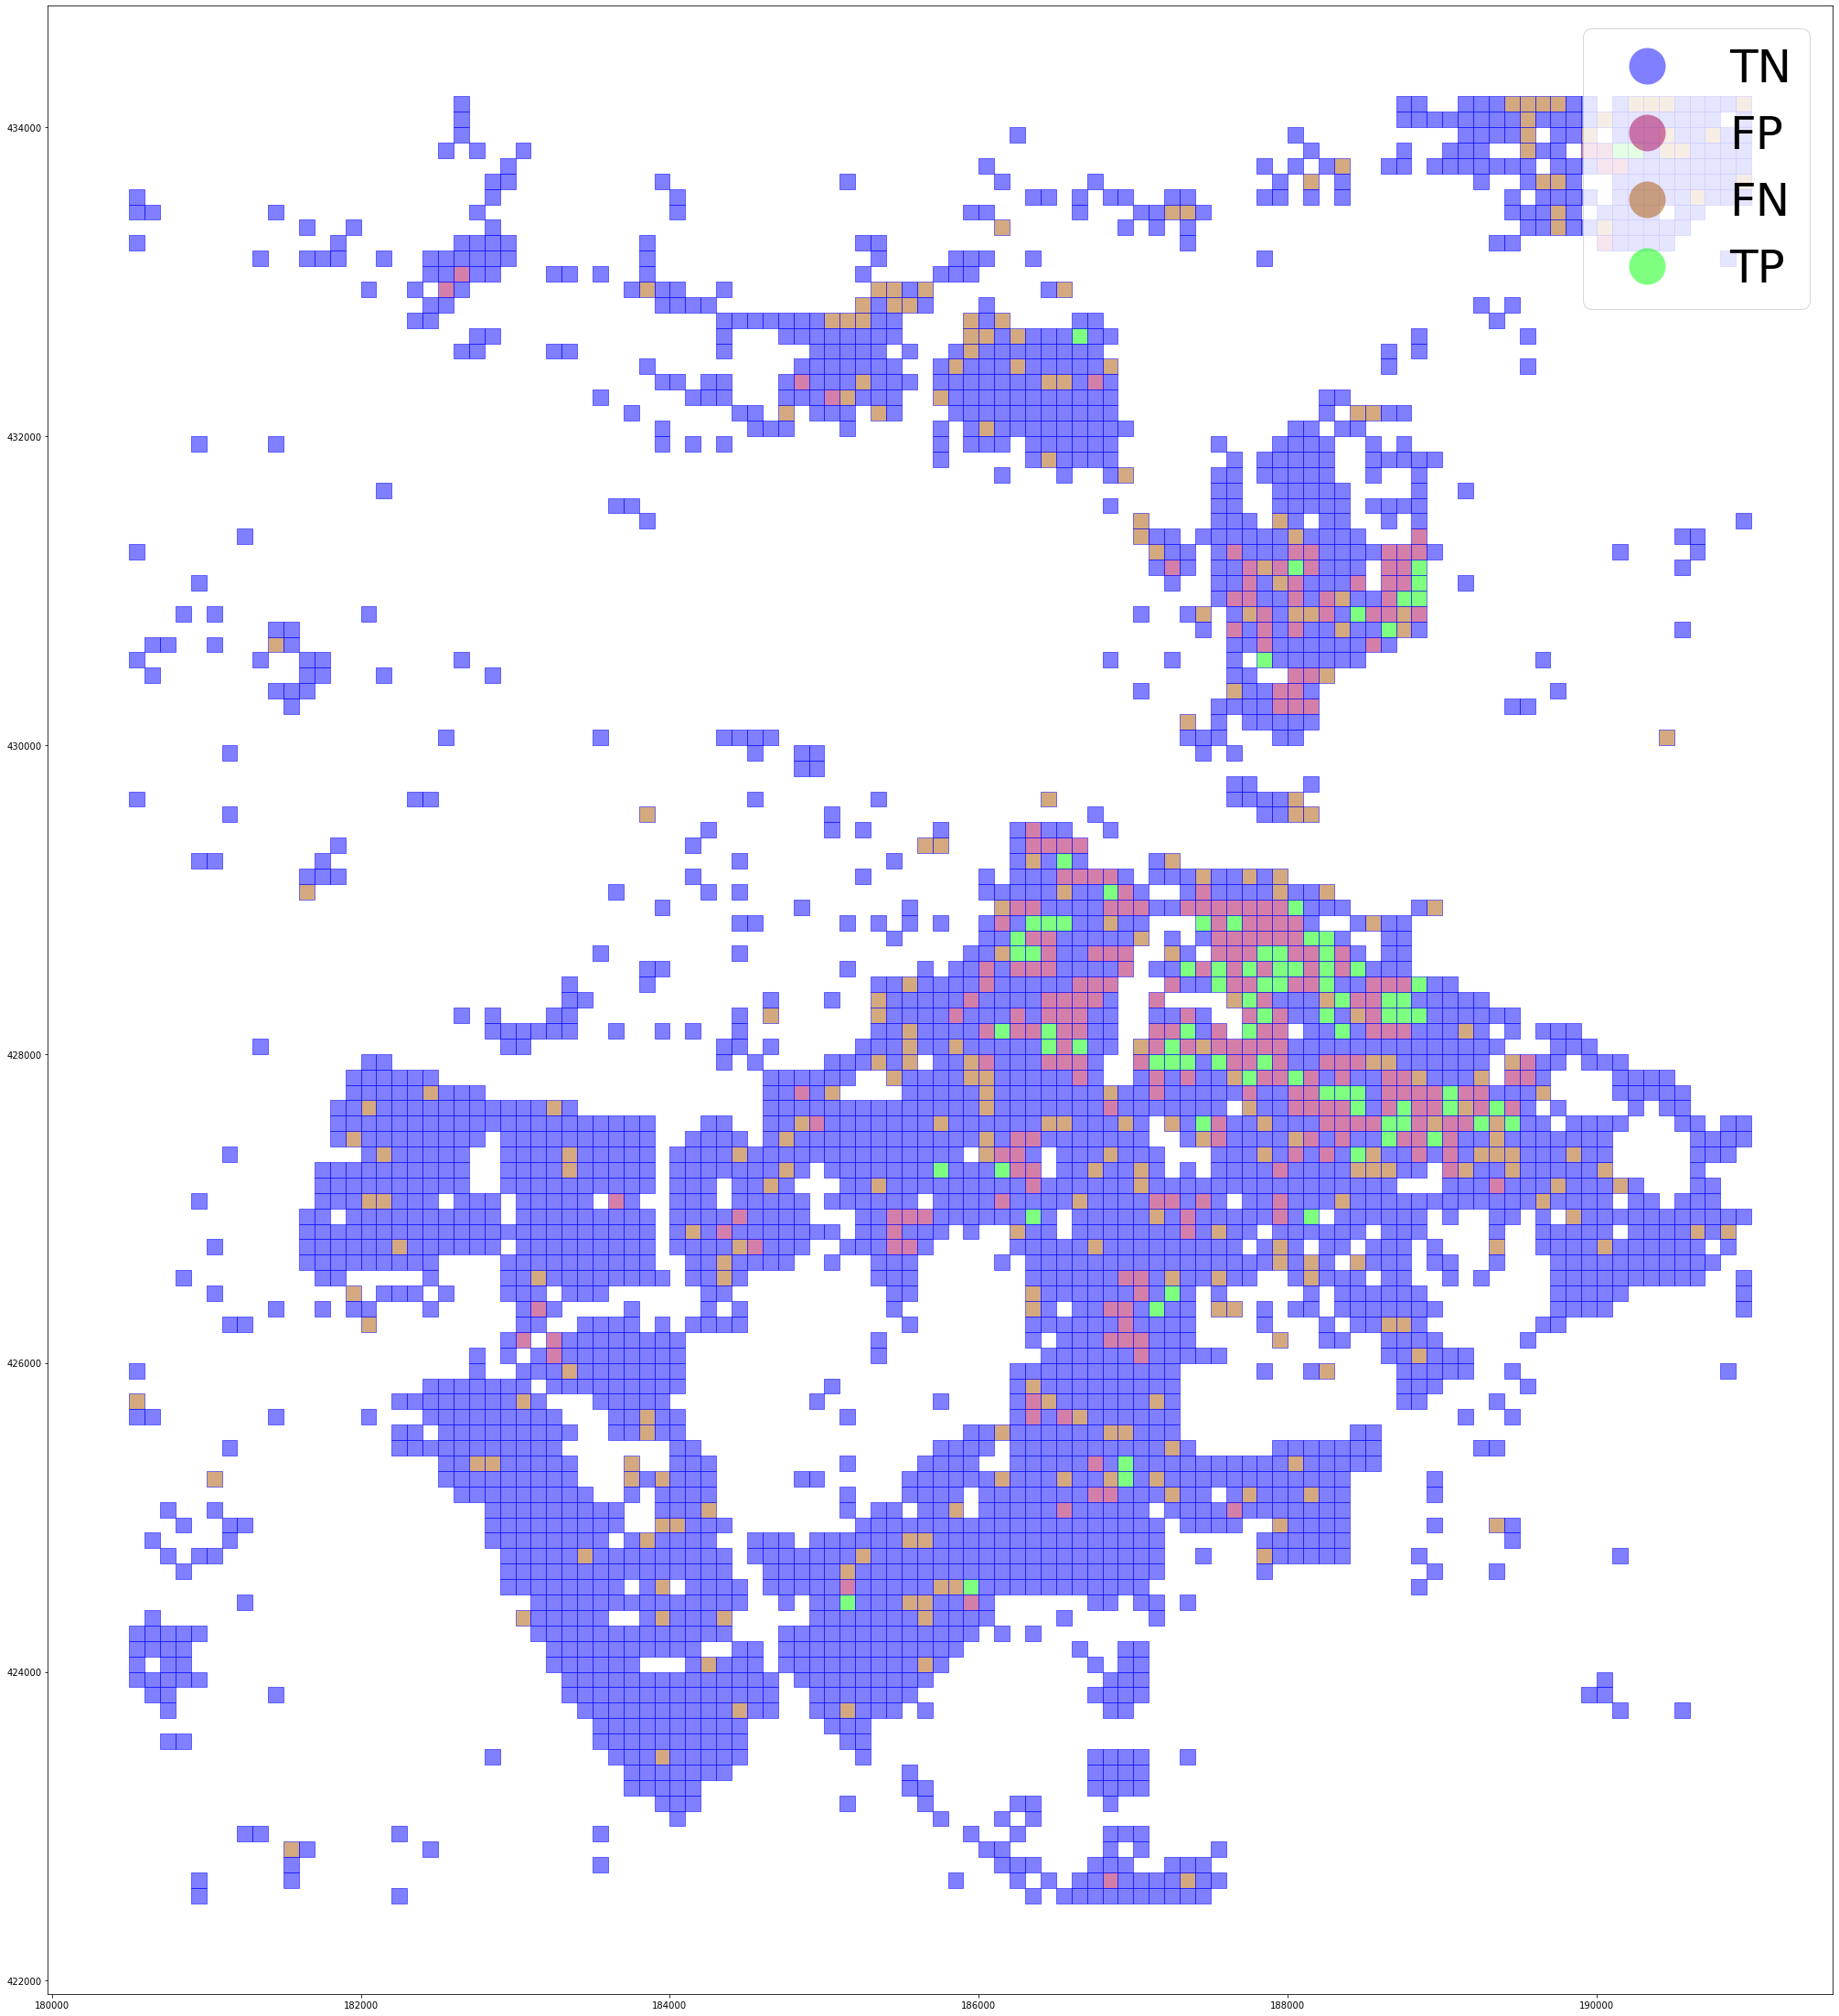

In [102]:
fig = plt.figure(figsize=(40, 40))
ax = plt.gca()
mapper = {0: "TN", 1: "FP", 2 : "FN", 3: "TP"}
df19.plot(figsize = (40,40), cmap = "brg", column = "checked", legend = True,
                                                           ax = ax, categorical=True, legend_kwds={'fontsize': 50, "markerscale":4},
                                                           alpha=0.5, edgecolor = "b")
def replace_legend_items(legend, mapping):
    for txt in legend.texts:
        for k,v in mapping.items():
            if txt.get_text() == str(k):
                txt.set_text(v)
                
legend = ax.get_legend()             
replace_legend_items(legend, mapper)
fig.savefig("../figures/Denhaagpredictions.png")

In [75]:
import pickle

In [103]:
import pickle
f = open('../results/NMRNNpreds','wb')
pickle.dump(preds,f)
f.close()